In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(8156, 28)
(8156, 2)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, 21] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [8]:
"""
for x in range(len(X_motion_CoM_FL_RR)):
    if X_motion_CoM_FL_RR[x, 0] == 0 and X_motion_CoM_FL_RR[x+1, 0] > 0 and X_motion_CoM_FL_RR[x+1, 0] < 0.2:
        print("FL: ", X_motion_CoM_FL_RR[x, 9:11], X_motion_CoM_FL_RR[x, 12:14], X_motion_CoM_FL_RR[x, 15:17], X_motion_CoM_FL_RR[x, 18:20])
        print("CoM step", Y_motion_CoM_FL_RR[x, 0])
        print("\n")
"""

'\nfor x in range(len(X_motion_CoM_FL_RR)):\n    if X_motion_CoM_FL_RR[x, 0] == 0 and X_motion_CoM_FL_RR[x+1, 0] > 0 and X_motion_CoM_FL_RR[x+1, 0] < 0.2:\n        print("FL: ", X_motion_CoM_FL_RR[x, 9:11], X_motion_CoM_FL_RR[x, 12:14], X_motion_CoM_FL_RR[x, 15:17], X_motion_CoM_FL_RR[x, 18:20])\n        print("CoM step", Y_motion_CoM_FL_RR[x, 0])\n        print("\n")\n'

In [9]:
idx_fl_rr_swinging.shape

(4089,)

## Predict CoM -> x

In [10]:
X_motion_CoM_FL_RR[0, :]

array([0.0, 0.0, 0.0, 0.0268696810059, -0.100021401849, 0.0175815529049,
       0.000165718385111, 0.0171657945462, 0.00360887973017,
       0.238365781714, 0.188972370044, -0.430276655111, 0.234579478816,
       -0.17174253164, -0.43064498367, -0.250112940119, 0.160852296745,
       -0.42957919654, -0.261250255657, -0.135911712455, -0.43009373378,
       True, False, False, True, 0.10000000149, 0.0, 0.0], dtype=object)

In [11]:
Y_motion_CoM_FL_RR[0, :]

array([0.007543431264000033, 0.017641978145999992], dtype=object)

### Linear Regression

In [12]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9813630819809817
RMSE:  0.0027745995980280143
The lowest error is:  3.313932453175017e-07
The highest error is:  0.04597160251793339
The avg. error is:  0.0013628753965293438


In [13]:
model_fl_com_x.coef_

array([[ 6.54563092e-03,  1.52655666e-16,  3.46944695e-18,
         1.15896646e-01,  9.02056208e-17,  2.77555756e-17,
         1.38169944e-01,  1.72517079e-02,  2.12918012e-02,
        -6.22313894e-01,  1.15911155e-01,  5.61062676e-02,
         2.25539252e-01,  7.80928988e-03]])

In [14]:
model_fl_com_x.intercept_

array([-0.07322172])

In [15]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

array([[-0.01311755]])

Text(0, 0.5, 'Predictions')

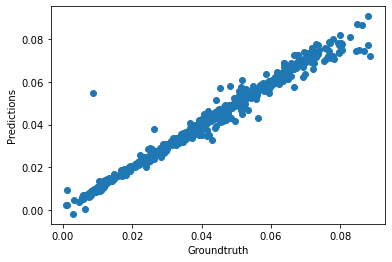

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [17]:
#%store model_fl_com_x

In [18]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [19]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM foot -> y

### Linear Regression

In [20]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) 

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8988305857485002
RMSE:  0.00181466892221304
The lowest error is:  9.73177707030981e-07
The highest error is:  0.02412668286153452
The avg. error is:  0.00114740918546949


In [21]:
model_fl_com_y.coef_

array([[ 1.22518324e-02,  2.94902991e-17,  0.00000000e+00,
         3.47193195e-02,  0.00000000e+00,  0.00000000e+00,
         1.39640048e-01,  3.72102951e-01, -1.33375853e-01,
        -6.58828109e-02, -2.21245720e-01,  1.99051695e-01,
         4.12489598e-02,  1.78561346e-01]])

In [22]:
model_fl_com_y.intercept_

array([-0.12347908])

Text(0, 0.5, 'Predictions')

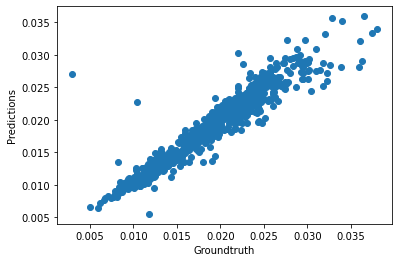

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [24]:
#%store model_fl_com_y

In [25]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [27]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")